In [1]:
import numpy as np
import pylab as plt
import matplotlib
from scipy.signal import welch
import seaborn as sns
import types
import time
from multiprocess import Pool

import tensorflow as tf
import tensorflow_probability as tfp


plt.style.use('ggplot')

# Utility function definitions

In [2]:
# sum the oscillators into one signal
# phiMatrix = phases
# A = amplitudes
def sumOsc(phiMatrix, A):
    A = np.resize(A, (1, len(A)))
    return A.dot(np.sin(phiMatrix)).sum(0)

# ODE function and Jacobian

In [3]:
def kuramoto_ODE_tf(t,y):
    a = tf.linalg.matvec(K_tf/nOsc, tf.reduce_sum(tf.sin(y - y[:,None]),1))
    #a = (K_tf/nOsc) * tf.reduce_sum(tf.sin(y - y[:,None]),1)
    return W_tf + a

def kuramoto_jac_tf(t,y):
    a = tf.cos(y[:,None] - y) - tf.eye(len(y), dtype=tf.double)
    b = -tf.reduce_sum(tf.cos(y - y[:,None]), 1) + tf.ones(len(y), dtype=tf.double)
    c = tf.linalg.diag(b)
    return (K_tf/nOsc) * (a + c)

def kuramoto_ODE_timeDependent_tf(t,y):
    K_tf = couplingMatrix(t)
    a = tf.linalg.matvec(K_tf/nOsc, tf.reduce_sum(tf.sin(y - y[:,None]),1))
    return W_tf + a

def kuramoto_jac_timeDependent_tf(t,y):
    K_tf = couplingMatrix(t)
    a = tf.cos(y[:,None] - y) - tf.eye(len(y), dtype=tf.double)
    b = -tf.reduce_sum(tf.cos(y - y[:,None]), 1) + tf.ones(len(y), dtype=tf.double)
    c = tf.linalg.diag(b)
    return (K_tf/nOsc) * (a + c)

def couplingMatrix(t):
    
    K1 = .001 * tf.eye(nOsc, dtype=tf.double)
    K2 = 40 * tf.eye(nOsc, dtype=tf.double)
    
    if t < 15.:
        return K1
    elif t < 20.:
        alpha = t - 15.
        return (alpha * K2) + ((1 - alpha) * K1)
    elif t < 25.:
        alpha = t - 20.
        return (alpha * K1) + ((1 - alpha) * K2)
    elif t >= 25.:
        return K1

# Set the parameters for the Kuramoto model.

In [5]:
# set these simulation parameters
nOsc = 200
upperTimeBound = 40
dt = 0.01

# Defining time array
numTimePoints = int(upperTimeBound/dt) + 1
T = np.linspace(0, upperTimeBound, numTimePoints)
 
# Y0, W, K, A are initial phase, intrinsic freq, amplitude and
# coupling K matrix (or list of K matricies) respectively 
# (note K can be arbitary, in particular inhomogeneous, in contrast to Kuramoto's original model)

Y0 = np.random.uniform(low=0.0, high=2*np.pi, size=nOsc)
W = 2 * np.pi * np.random.normal(loc=20, scale=2, size=nOsc)
A = np.ones(nOsc)

W_tf = tf.constant(W)
K_tf = tf.constant(100. * tf.eye(nOsc, dtype=tf.double))

# Numerically solve the model and plot the results.

In [6]:
completeTimeFlag = True

if completeTimeFlag:
    solution_times = T
    ode_fn = kuramoto_ODE_timeDependent_tf
    jacobian_fn = kuramoto_jac_timeDependent_tf
else:
    solution_times=tfp.math.ode.ChosenBySolver(final_time=upperTimeBound)
    ode_fn = kuramoto_ODE_tf
    jacobian_fn = kuramoto_jac_tf


print("Solving ODEs...")
start = time.time()

results = tfp.math.ode.BDF().solve(ode_fn=ode_fn, 
                            initial_time=0, 
                            initial_state=Y0, 
                            solution_times=solution_times, 
                            jacobian_fn=jacobian_fn)
print("Finished.")
print("Seconds elapsed: {}".format(time.time() - start))

odePhi = results.states.numpy().T
times = results.times.numpy()
orderParameterAbs = [np.abs(np.exp(odePhi[:,i] * (0+1j)).sum())  for i in range(odePhi.shape[1])]

Solving ODEs...
Finished.
Seconds elapsed: 370.9318561553955


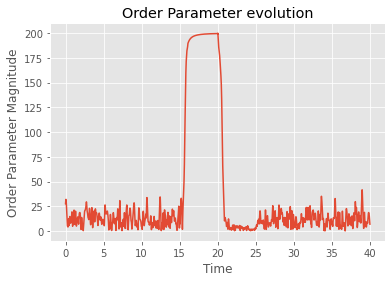

In [7]:
plt.figure()
plt.plot(times, orderParameterAbs)
plt.ylabel('Order Parameter Magnitude')
plt.xlabel('Time');
plt.title('Order Parameter evolution');

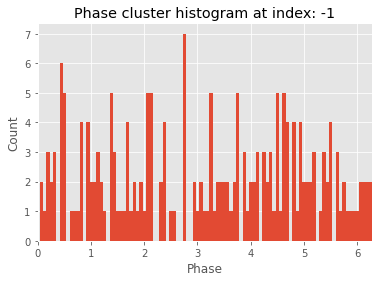

In [8]:
index = -1

plt.figure()
plt.hist(np.mod(odePhi[:,index], 2*np.pi),100)
plt.xlim([0, 2 * np.pi])
plt.xlabel('Phase');
plt.ylabel('Count');
plt.title('Phase cluster histogram at index: {}'.format(index))
plt.show()

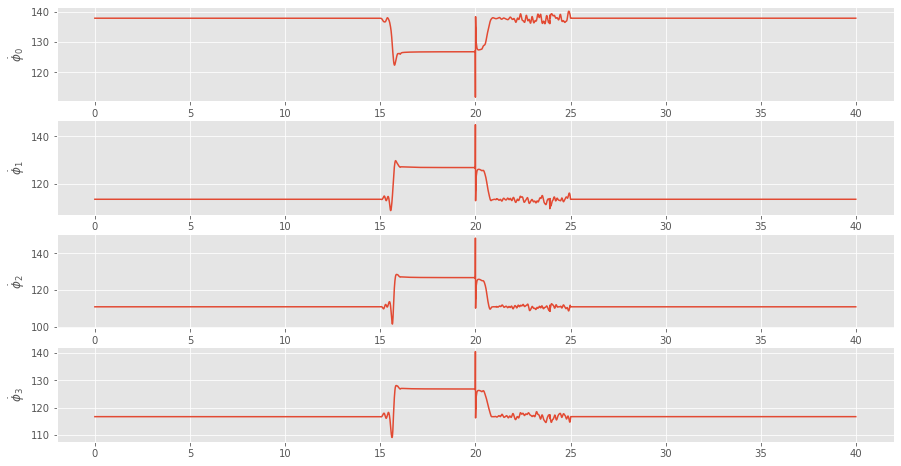

In [9]:
# Plotting response
if completeTimeFlag:
    oscList = range(4)
    
    angularVelocity = np.diff(odePhi)/dt
    lenPlot = len(oscList)
    plt.figure(figsize=(15,2 * lenPlot))
    for i, osc in enumerate(oscList):
        plt.subplot(lenPlot, 1, 1+i)
        plt.plot(T[:-1], angularVelocity[osc])
        plt.ylabel("$\dot\phi_{%i}$" %(osc))

# Figure 3a.1 Plot the sum of the oscillators

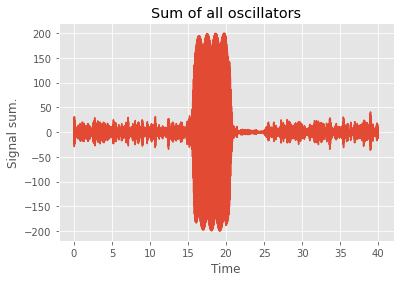

In [10]:
if completeTimeFlag:
    plt.figure(figsize=(15,10))
    sumSignal = sumOsc(odePhi, A)
    plt.plot(times, sumSignal)
    plt.xlabel('Time')
    plt.ylabel('Signal sum.')
    plt.title("Sum of all oscillators");

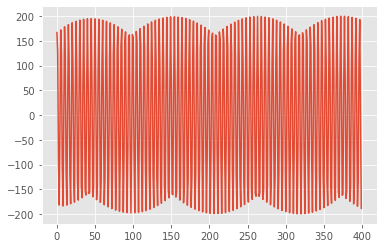

In [11]:
plt.figure()
sumSignal = sumOsc(odePhi, A)
sig = sumSignal[1600:2000]
plt.plot(sig)

# Figure 3a.2

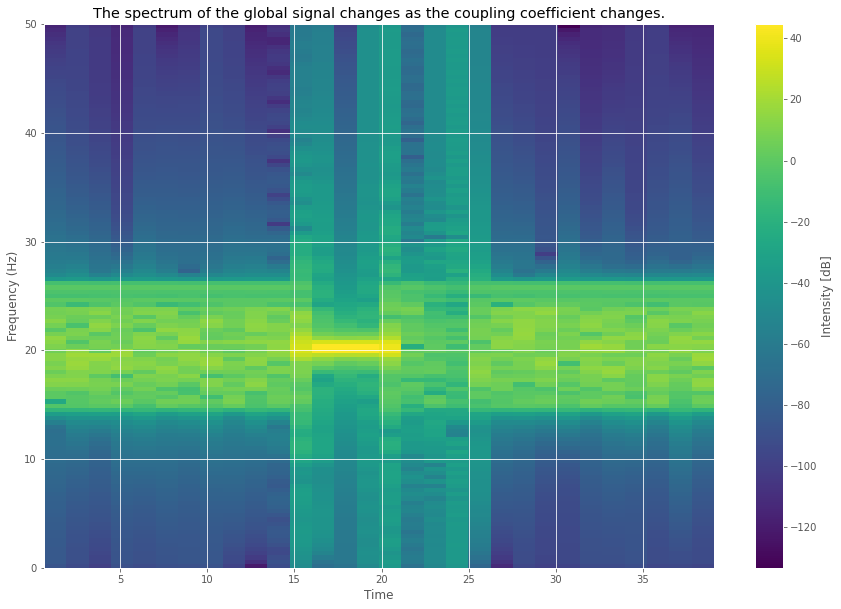

In [12]:
fig=plt.figure(figsize=(15,10))
pxx,  freq, t, cax = plt.specgram(sumSignal, Fs=100);
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
fig.colorbar(cax).set_label('Intensity [dB]')
plt.title('The spectrum of the global signal as the coupling coefficient changes.');

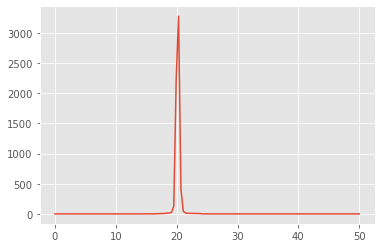

In [13]:
f, psd = welch(sumSignal, fs=100)
plt.plot(f,psd);

In [14]:
parameterList = []
solution_times=tfp.math.ode.ChosenBySolver(final_time=10)
ode_fn = kuramoto_ODE_tf
jacobian_fn = kuramoto_jac_tf
    
for k in np.linspace(1,100,1001):
    K_tf = tf.constant(k * tf.eye(nOsc, dtype=tf.double))
    results = tfp.math.ode.BDF().solve(ode_fn=ode_fn, 
                                initial_time=0, 
                                initial_state=Y0, 
                                solution_times=solution_times, 
                                jacobian_fn=jacobian_fn)
    
    odePhi = results.states.numpy().T
    finalOrderParamter = np.abs(np.exp(odePhi[:,-1] * (0+1j)).sum())
    parameterList.append(finalOrderParamter)

# Figure 3b

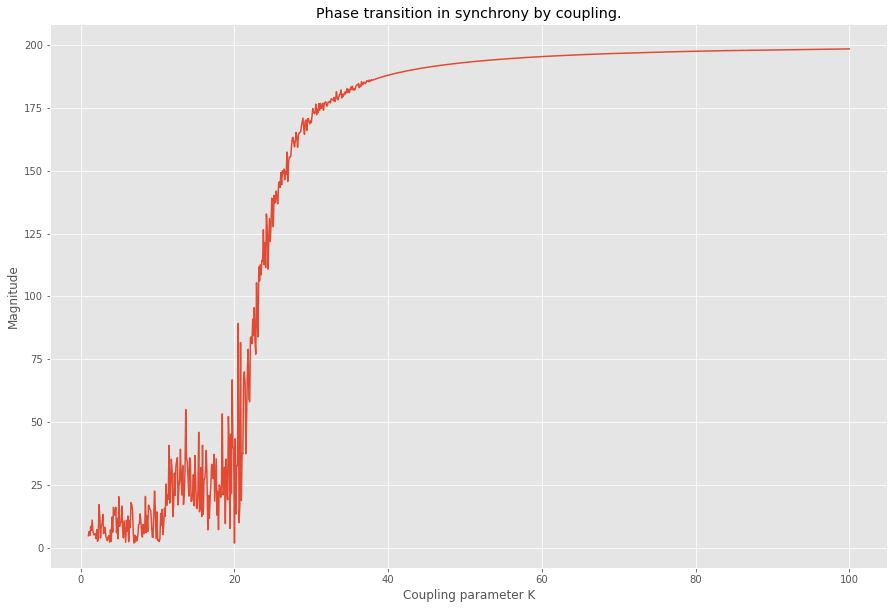

In [15]:
plt.figure(figsize=(15,10))
plt.plot(np.linspace(1,100,1001),parameterList)
plt.xlabel('Coupling parameter K')
plt.ylabel('Magnitude of order parameter at equilibrium (if equilibrium exists)')
plt.title('Phase transition in synchrony by coupling.');

# Figure 3c

In [ ]:
orderParameterMatrix = []
solution_times=tfp.math.ode.ChosenBySolver(final_time=10)
ode_fn = kuramoto_ODE_tf
jacobian_fn = kuramoto_jac_tf
    
for sigma in np.linspace(1,10,91):
    print(sigma)
    newRow = []
    W_tf = tf.constant(2 * np.pi * np.random.normal(loc=20, scale=sigma, size=nOsc), dtype=tf.double)
    for k in range(1,101):
        K_tf = tf.constant(k * tf.eye(nOsc, dtype=tf.double))
        results = tfp.math.ode.BDF().solve(ode_fn=ode_fn, 
                                    initial_time=0, 
                                    initial_state=Y0, 
                                    solution_times=solution_times, 
                                    jacobian_fn=jacobian_fn)

        odePhi = results.states.numpy().T
        finalOrderParamter = np.abs(np.exp(odePhi[:,-1] * (0+1j)).sum())
        newRow.append(finalOrderParamter)
    orderParameterMatrix.append(newRow)
    
orderParameterMatrix = np.array(orderParameterMatrix)

1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7000000000000002
1.8
1.9
2.0
2.1
2.2
2.3
2.4000000000000004
2.5
2.6
2.7
2.8
2.9000000000000004
3.0
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1
4.2
4.300000000000001
4.4
4.5
4.6
4.7
4.800000000000001
4.9
5.0


In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(orderParameterMatrix, aspect='auto', origin='lower')
plt.xlabel('Coupling parameter K')
plt.ylabel('Standard deviation of initial frequencies')
plt.colorbar().set_label('Magnitude of order parameter')
plt.title('Coupling/Dispersion relationship for 200 oscillators.  Mean frequency is 20Hz');

# Scratch

In [ ]:
# The Kuramoto class, borrowed from http://www.laszukdawid.com/codes, and modified to permit time-varying coupling.

from __future__ import print_function

import numpy as np
from scipy.integrate import ode

__version__ = '0.3'
__author__ = 'Dawid Laszuk'

class Kuramoto(object):
    """
    Implementation of Kuramoto coupling model [1] with harmonic terms
    and possible perturbation.
    It uses NumPy and Scipy's implementation of Runge-Kutta 4(5)
    for numerical integration.

    Usage example:
    >>> kuramoto = Kuramoto(initial_values)
    >>> phase = kuramoto.solve(X)
    """

    def __init__(self, init_values):
        """
        Passed arguments should be a dictionary with NumPy arrays
        for initial phase (Y0), intrisic frequencies (W) and coupling
        matrix (K).
        """
        self.dtype = np.float32

        self.dt = 1.
        self.init_phase = np.array(init_values['Y0'])
        self.W = np.array(init_values['W'])

        self.n_osc = len(self.W)

        if isinstance(init_values['K'], list) or isinstance(init_values['K'], types.GeneratorType):
            self.m_order = 1
            self.K = init_values['K']
        else:
            self.m_order = 1
            self.K = np.array(init_values['K'])
        

    def kuramoto_ODE(self, t, y, arg):
        """General Kuramoto ODE of m'th harmonic order.
           Argument `arg` = (w, k), with
            w -- iterable frequency
            k -- 3D coupling matrix, unless 1st order
            """

        w, k = arg
        yt = y[:,None]
        dy = y-yt
        phase = w.astype(self.dtype)
        for m, _k in enumerate(k):
            phase += np.sum(_k*np.sin((m+1)*dy),axis=1)

        return phase

    def kuramoto_ODE_jac(self, t, y, arg):
        """Kuramoto's Jacobian passed for ODE solver."""

        w, k = arg
        yt = y[:,None]
        dy = y-yt

        phase = [m*k[m-1]*np.cos(m*dy) for m in range(1,1+self.m_order)]
        phase = np.sum(phase, axis=0)

        for i in range(self.n_osc):
            phase[i,i] = -np.sum(phase[:,i])

        return phase

    def solve(self, t):
        """Solves Kuramoto ODE for time series `t` with initial
        parameters passed when initiated object.
        """
        dt = t[1]-t[0]

        kODE = ode(self.kuramoto_ODE, jac=self.kuramoto_ODE_jac)
        
        #kODE.set_integrator("dopri5", nsteps=20000)
        #kODE.set_integrator("lsoda", nsteps=20000)
        kODE.set_integrator("vode", nsteps=20000)
        
        # Set parameters into model
        kODE.set_initial_value(self.init_phase, t[0])
        
        if isinstance(self.K, np.ndarray):
            kODE.set_f_params((self.W, self.K))
            kODE.set_jac_params((self.W, self.K))
        elif isinstance(self.K, types.GeneratorType):
            throwAwayFirst = next(self.K)

        phase = np.empty((self.n_osc, len(t)))
        
        # Run ODE integrator
        for idx, _t in enumerate(t[1:]):
            if idx % int(len(t)/10) == 0:
                print(idx)
            if isinstance(self.K, list):
                kODE.set_f_params((self.W, self.K[idx]))
                kODE.set_jac_params((self.W, self.K[idx]))
            elif isinstance(self.K, types.GeneratorType):
                thisK = next(self.K)
                kODE.set_f_params((self.W, thisK))
                kODE.set_jac_params((self.W, thisK))
            phase[:,idx] = kODE.y
            kODE.integrate(_t)

        phase[:,-1] = kODE.y

        return phase

In [ ]:
def linearKList(KpointList, changePoints, dt):
    Klist = []
    for i in range(1,len(changePoints)):
        thisList = []
        startMatrix = KpointList[i-1]
        endMatrix = KpointList[i]
        numTimePoints = int(np.ceil((changePoints[i] - changePoints[i-1])/dt)) + 1
        for j in np.linspace(0,1,numTimePoints)[0:-1]:
            thisMatrix = ((1-j) * startMatrix) + (j * endMatrix)
            thisList.append(thisMatrix.copy())
        Klist.extend(thisList)
    Klist.append(endMatrix.copy())
    return Klist

# make a generator of coupling matrices that evolve piecewise linearly
# KpointList is a list of coupling matrices
# changePoints is a list of time points at which the corresponding matrices hold
# In between the change points the matrices evolve linearly from first to second
# dt is the time step
def linearKGenerator(KpointList, changePoints, dt):
    for i in range(1,len(changePoints)):
        thisList = []
        startMatrix = KpointList[i-1]
        endMatrix = KpointList[i]
        numTimePoints = int(np.ceil((changePoints[i] - changePoints[i-1])/dt)) + 1
        for j in np.linspace(0,1,numTimePoints)[0:-1]:
            thisMatrix = ((1-j) * startMatrix) + (j * endMatrix)
            yield tf.constant(thisMatrix, dtype=tf.double)
    yield tf.constant(endMatrix, dtype=tf.double)
    
def negPosK(nOsc, probNeg):
    K = np.ones(shape=(nOsc,nOsc))
    for i in range(nOsc):
        for j in range(i):
            q = np.random.uniform()
            if q <= probNeg:
                K[i,j] = -1
                K[j,i] = -1
    return K